In [128]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py that executed in 36 hours

In [129]:
#monitor execution time
import time as tm
t_start = tm.time()

In [130]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('nothing')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  158


['permutations/sim_id=10!total_ring_mass=3.330000000000004e-13!shear_viscosity=3.3000000000000023e-14!timesteps_per_output=505!radial_width=0.0001!bulk_viscosity=3.3000000000000023e-14!',
 'permutations/sim_id=151!total_ring_mass=9.999999999999996e-11!shear_viscosity=3.3000000000000023e-14!timesteps_per_output=2199!radial_width=0.0002!bulk_viscosity=3.3000000000000023e-14!',
 'permutations/sim_id=50!total_ring_mass=1.042210362128438e-12!shear_viscosity=1.0435516278555659e-12!timesteps_per_output=15!radial_width=0.0001!bulk_viscosity=1.0435516278555659e-12!',
 'permutations/sim_id=78!total_ring_mass=3.2618691859696355e-12!shear_viscosity=1.0435516278555659e-12!timesteps_per_output=15!radial_width=0.0001!bulk_viscosity=1.0435516278555659e-12!',
 'permutations/sim_id=120!total_ring_mass=3.195132308221693e-11!shear_viscosity=3.3000000000000023e-14!timesteps_per_output=1116!radial_width=2.5e-05!bulk_viscosity=3.3000000000000023e-14!']

In [131]:
#prep plots
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [132]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('!total_ring_mass=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

,sim_id,path
0,0,permutations/sim_id=0!total_ring_mass=3.330000...
1,1,permutations/sim_id=1!total_ring_mass=3.330000...
2,2,permutations/sim_id=2!total_ring_mass=3.330000...
3,3,permutations/sim_id=3!total_ring_mass=3.330000...
4,4,permutations/sim_id=4!total_ring_mass=3.330000...


In [133]:
#set power laws for ringlet's dynamical timescale = time for q to reach 0.6, which is assumed to vary as 
#(ringlet_mass**mass_power_law)*(viscosity**viscosity_power_law)*(radial_width**width_power_law)
nominal_dynamical_timescale = 2.85e4
mass_power_law = 1.05
viscosity_power_law = -0.95
width_power_law = -0.25
nominal_total_ring_mass = 3.33e-11
nominal_shear_viscosity = 1.0e-13
nominal_radial_width = 0.00005

In [134]:
#get outcome of every sim
debug = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in paths_df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    nan_timestep = monitor['nan_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['nan_timestep'] = nan_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path
    
    #check if sim completed
    d['outcome'] = 'unknown'
    if ((streamline_crossing_timestep > 0) or (nan_timestep > 0)):
        d['outcome'] = 'crossed streamlines'
    if (streamline_crossing_timestep == None):
        if (nan_timestep == None):
            if (current_timestep == expected_timestep):
                d['outcome'] = 'simulation complete'
    
    #collect stats from completed sims
    if (d['outcome'] == 'simulation complete'):
        
        #compute ringlet's predicted dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/nominal_total_ring_mass)**mass_power_law
        dynamical_timescale *= (shear_viscosity/nominal_shear_viscosity)**viscosity_power_law
        dynamical_timescale *= (radial_width/nominal_radial_width)**width_power_law
        times_dynamical = times/dynamical_timescale
        d['dynamical_timescale'] = dynamical_timescale
        
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
        da_init = da[0]
    
        #compute e_prime, wt_prime, q to lowest order, and H(q)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        jdx = (times > 0.8*times.max())
        d['q'] = q[jdx].mean()
        d['delta_q'] = 0.5*(q[jdx].max() - q[jdx].min())
        d['wt_prime'] = wt_prime[jdx].mean()
        d['e_prime'] = e_prime[jdx].mean()
        d['delta_q_over_q'] = d['delta_q']/d['q']

        #outcome=self-confining provided sim completes with q > 0.8
        if (d['q'] > 0.8):
            d['outcome'] = 'self-confining'
            e_prime_brackets = [0.0, 0.2, 0.5, 0.8]
            for e_prime_bracket in e_prime_brackets:
                if (d['e_prime'] > e_prime_bracket):
                    d['e_prime_bracket'] = e_prime_bracket
            #compute observed dynamical_timescale=time when q exceeds 0.6
            jdx = (q > 0.6)
            d['dynamical_timescale_obs'] = times[jdx][0]
        else: 
            d['outcome'] = 'unsure'
    
    data += [d]

df = pd.DataFrame(data)
print (df.outcome.value_counts())
df['nominal'] = False
small = 1.0e-15
df['r'] = np.abs(df.total_ring_mass - nominal_total_ring_mass + small) * \
    np.abs(df.shear_viscosity - nominal_shear_viscosity + small) * \
    np.abs(df.radial_width - nominal_radial_width + small)
idx = df.r.values.argmin()
df.loc[idx, 'nominal'] = True
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'dynamical_timescale_obs', 'timesteps_per_output', 'total_ring_mass', 'radial_width', 
    'shear_viscosity', 'bulk_viscosity', 'q', 'delta_q', 'delta_q_over_q', 'e_prime', 'wt_prime', 'outcome', 
    'e_prime_bracket', 'nominal', 'path']
df = df[cols]
df = df.sort_values('sim_id').reset_index(drop=True)
df_results = df
df_results.sample(5)

self-confining         72
crossed streamlines    46
unsure                 40
Name: outcome, dtype: int64


,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,nan_timestep,dynamical_timescale,dynamical_timescale_obs,timesteps_per_output,total_ring_mass,radial_width,shear_viscosity,bulk_viscosity,q,delta_q,delta_q_over_q,e_prime,wt_prime,outcome,e_prime_bracket,nominal,path
85,85,2525000,2525000,NaN,NaN,210434.406791,198212.5,2525,1.020887e-11,0.000050,3.300000e-15,3.300000e-15,0.873862,0.011437,0.013088,0.873721,-0.007791,self-confining,0.8,False,permutations/sim_id=85!total_ring_mass=1.02088...
28,28,315000,315000,NaN,NaN,22792.965178,6772.5,315,1.042210e-12,0.000025,3.300000e-15,3.300000e-15,0.873706,0.035687,0.040845,0.868284,-0.085819,self-confining,0.8,False,permutations/sim_id=28!total_ring_mass=1.04221...
133,136,14000,14000,NaN,NaN,1171.280626,NaN,14,3.195132e-11,0.000025,3.300000e-12,3.300000e-12,0.509203,0.055855,0.109692,0.077803,-0.503221,unsure,NaN,False,permutations/sim_id=136!total_ring_mass=3.1951...
68,68,34000,34000,NaN,NaN,2838.491107,7684.0,34,3.261869e-12,0.000025,1.043552e-13,1.043552e-13,0.898714,0.030481,0.033916,0.542739,-0.712866,self-confining,0.5,False,permutations/sim_id=68!total_ring_mass=3.26186...
83,83,20000,20000,NaN,NaN,63.432969,NaN,20,3.261869e-12,0.000200,3.300000e-12,3.300000e-12,0.786748,0.066678,0.084751,0.034589,-0.785987,unsure,NaN,False,permutations/sim_id=83!total_ring_mass=3.26186...


In [135]:
#confirm nominal ringlet sim
df = df_results
idx = (df.nominal == True)
print ('nominal sim_id = ', df[idx].sim_id.values[0])
df[idx]

('nominal sim_id = ', 125)


,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,nan_timestep,dynamical_timescale,dynamical_timescale_obs,timesteps_per_output,total_ring_mass,radial_width,shear_viscosity,bulk_viscosity,q,delta_q,delta_q_over_q,e_prime,wt_prime,outcome,e_prime_bracket,nominal,path
122,125,314000,314000,NaN,NaN,26206.164389,25905.0,314,3.195132e-11,0.00005,1.043552e-13,1.043552e-13,0.877987,0.001966,0.00224,0.87474,-0.07539,self-confining,0.8,True,permutations/sim_id=125!total_ring_mass=3.1951...


In [136]:
#examine e_prime_bracket distribution
df = df_results
idx = (df.outcome == 'self-confining')
df = df[idx]
df.e_prime_bracket.value_counts().sort_index(ascending=False)

0.8    41
0.5    14
0.2    10
0.0     7
Name: e_prime_bracket, dtype: int64

file =  figs/sim_grid_da_2.5e-05.pdf
file =  figs/sim_grid_da_5e-05.pdf
file =  figs/sim_grid_da_0.0001.pdf
file =  figs/sim_grid_da_0.0002.pdf


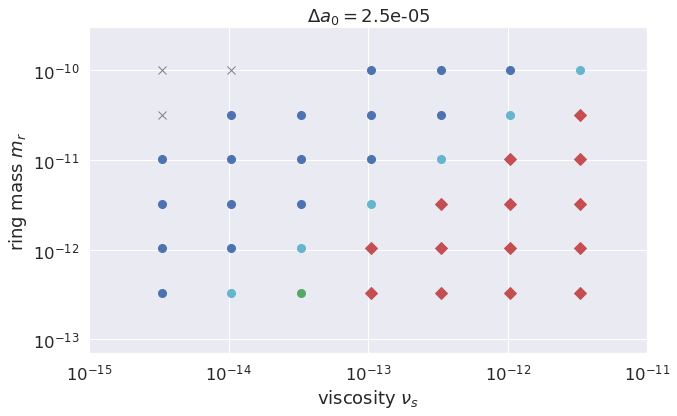

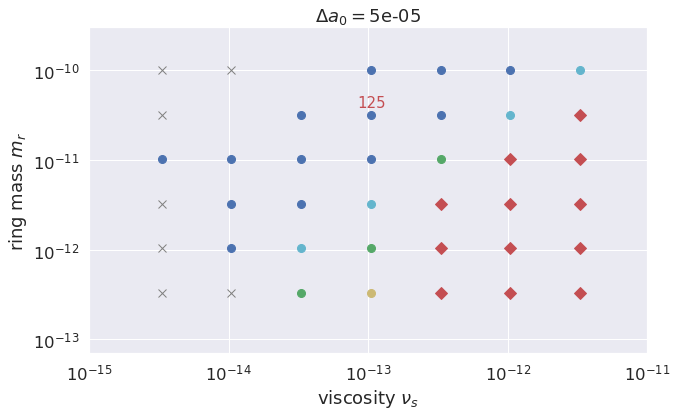

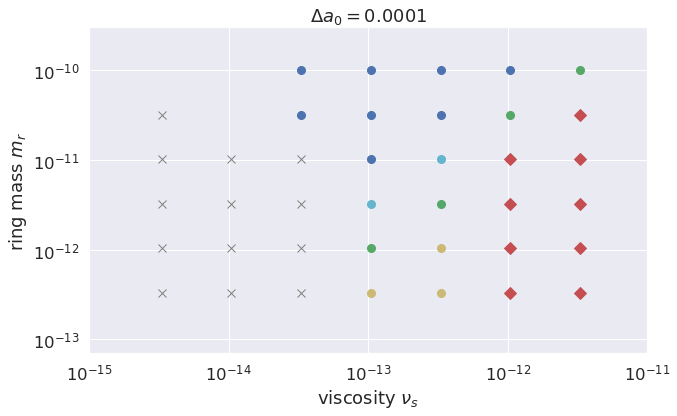

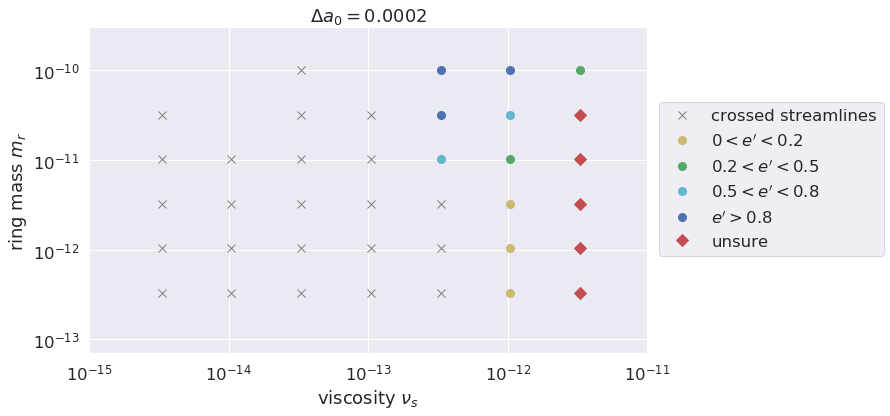

In [137]:
#show grid of simulation outcomes
df = df_results
radial_widths = np.sort(df.radial_width.unique())
e_prime_brackets = [(0.0, r"$0 < e'<0.2$", color_seq[8]),
                    (0.2, r"$0.2<e'<0.5$", color_seq[2]),
                    (0.5, r"$0.5<e'<0.8$", color_seq[9]),
                    (0.8, r"$e'>0.8$", color_seq[0])]
for radial_width in radial_widths:
    idx = (df.radial_width == radial_width)
    dfs = df[idx]
    sns.set(font_scale=1.5, font='DejaVu Sans')
    f, ax = plt.subplots(figsize=(10, 6))
    #x for sims that crossed streamlines
    idx = (dfs.outcome == 'crossed streamlines')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=8, color='grey', label='crossed streamlines')
    #dot for self-confining sims
    idx = (dfs.outcome == 'self-confining')
    dfss = dfs[idx]
    for e_prime_bracket, label, color in e_prime_brackets:
        idx = (dfss.e_prime_bracket == e_prime_bracket)
        dfsss = dfss[idx]
        xp = dfsss.shear_viscosity
        yp = dfsss.total_ring_mass
        p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=8, label=label, color=color)
    #diamond for unsure sims
    idx = (dfs.outcome == 'unsure')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    color = color_seq[3]
    p = ax.plot(xp, yp, linestyle='none', marker='D', markersize=8, color=color, label='unsure')
    #annotate the nominal sim_id
    idx = (dfs.nominal == True)
    if (idx.sum() > 0):
        dfss = dfs[idx]
        sim_id = str(dfss.sim_id.values[0])
        xp = dfss.shear_viscosity.values[0]
        yp = dfss.total_ring_mass.values[0]
        xy = (0.8*xp, 1.2*yp)
        color = color_seq[3]
        p = ax.annotate(sim_id, xy, fontsize=15, color=color)
    p = ax.set_xscale('log')
    p = ax.set_yscale('log')
    p = ax.set_xlabel(r'viscosity $\nu_s$')
    p = ax.set_ylabel(r'ring mass $m_r$')
    title = r'$\Delta a_0 = $' + str(radial_width)
    p = ax.set_title(title)
    p = ax.set_ylim(7.0e-14, 3.0e-10)
    p = ax.set_xlim(1.0e-15, 1.0e-11)
    if (radial_width == radial_widths[-1]):
        p = ax.legend(loc=(1.02, 0.3))
    file = 'figs/sim_grid_da_'+ str(radial_width) + '.pdf'
    print 'file = ', file
    plt.savefig(file, bbox_inches='tight')

In [138]:
#conda install scikit-learn

In [155]:
#fit power-law to those sims having delta_q_over_q < max_delta_q_over_q
max_delta_q_over_q = 5.0e-2
min_e_prime_bracket = 0.4

number of self-confining sims with (delta_q_over_q < max_delta_q_over_q) =  55


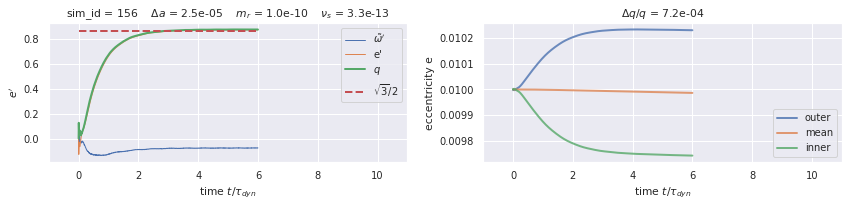

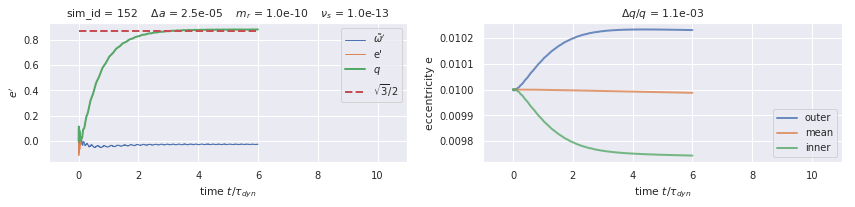

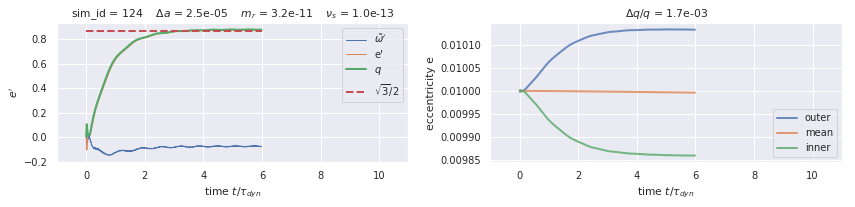

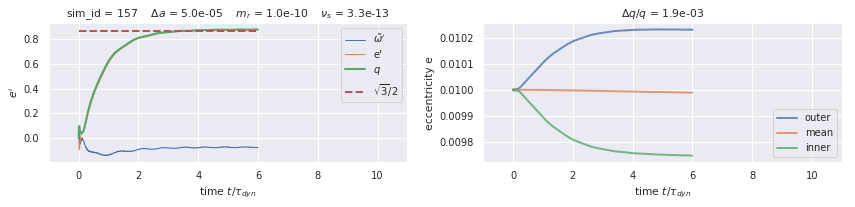

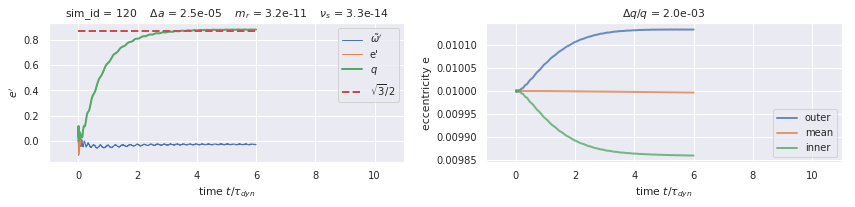

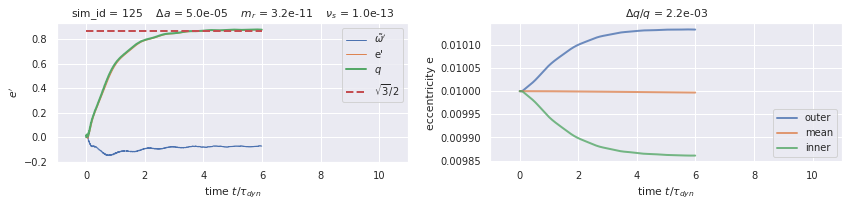

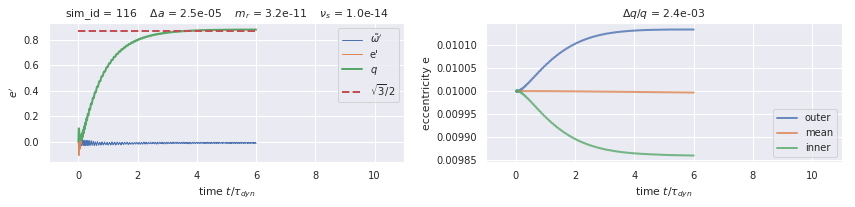

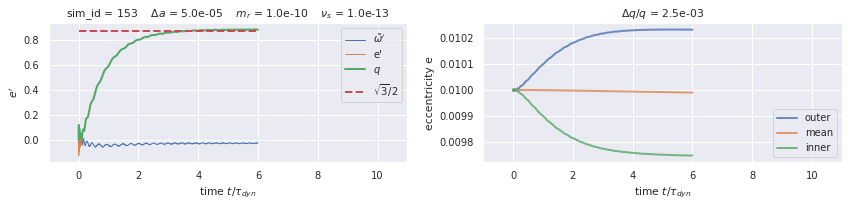

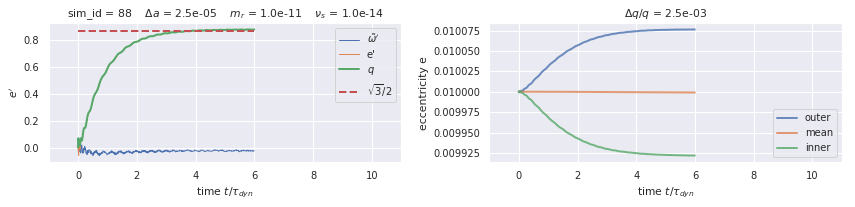

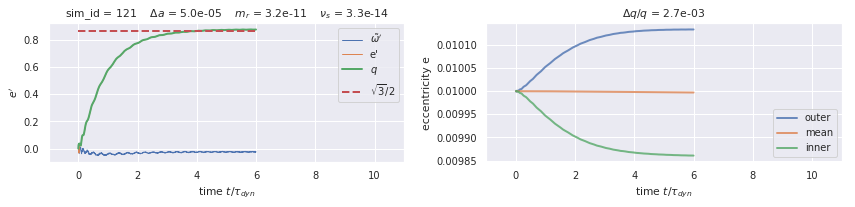

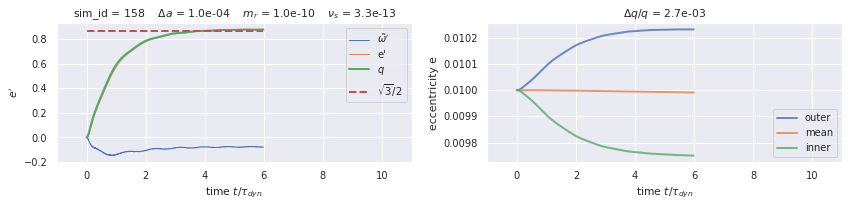

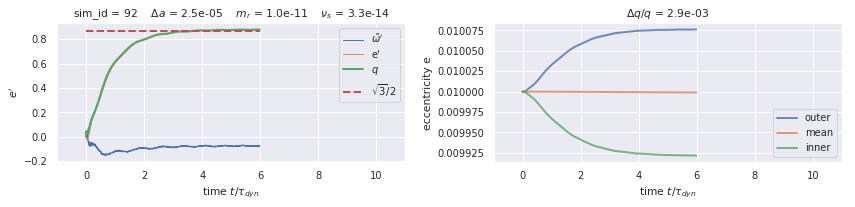

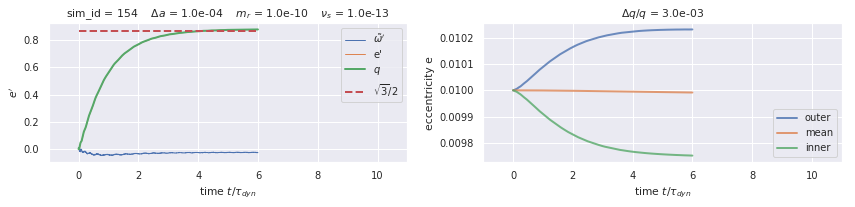

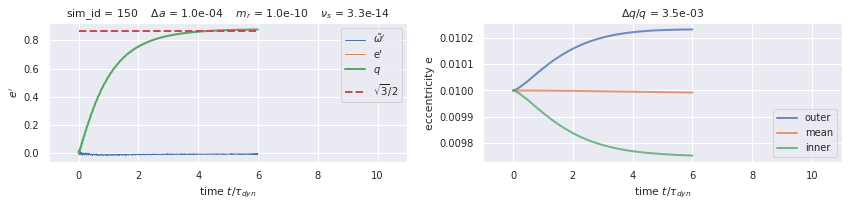

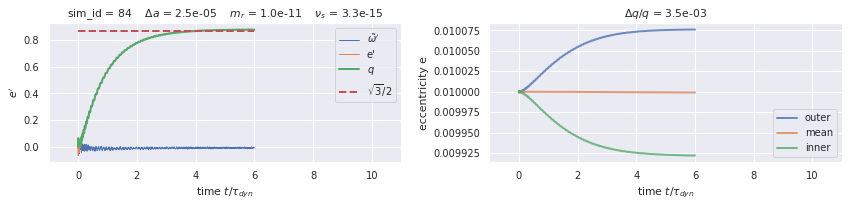

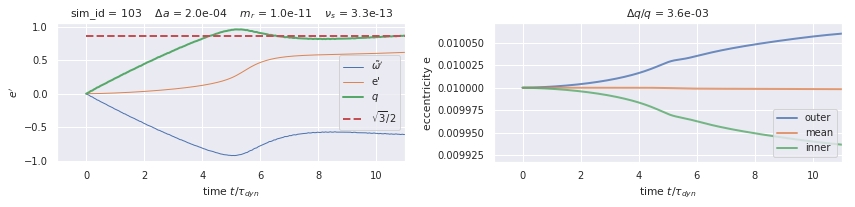

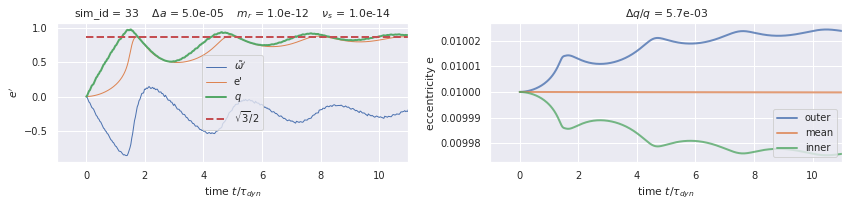

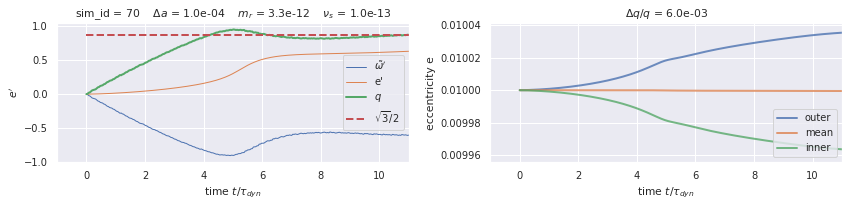

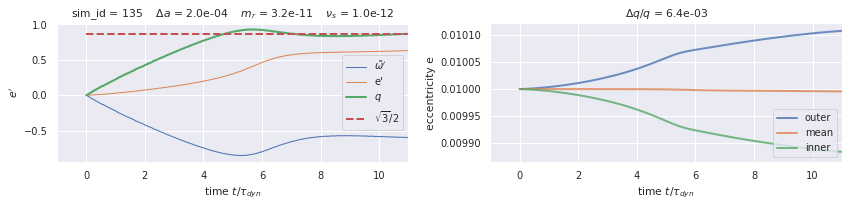

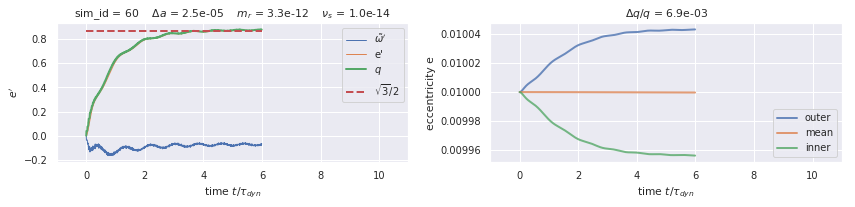

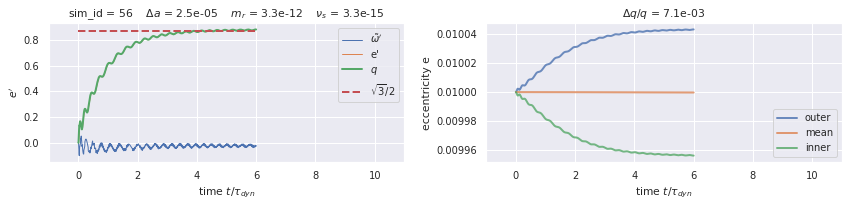

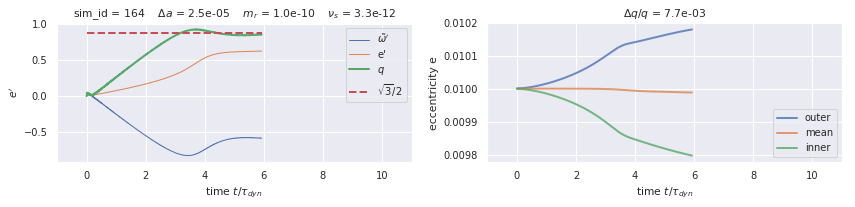

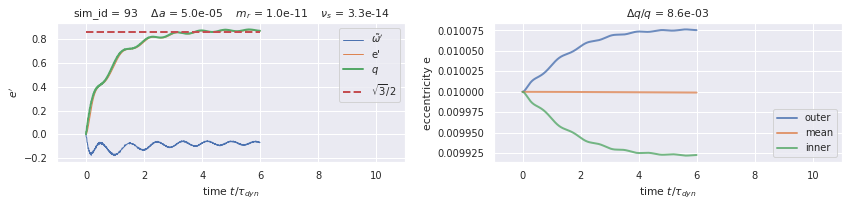

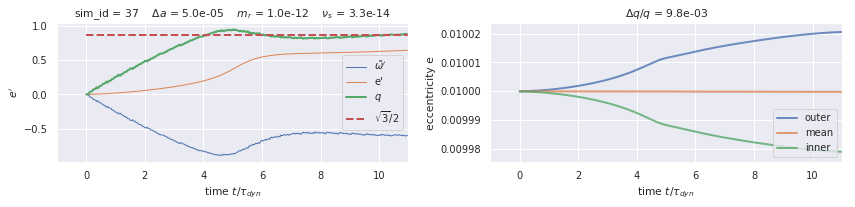

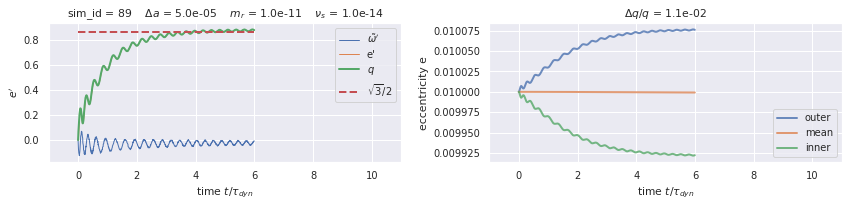

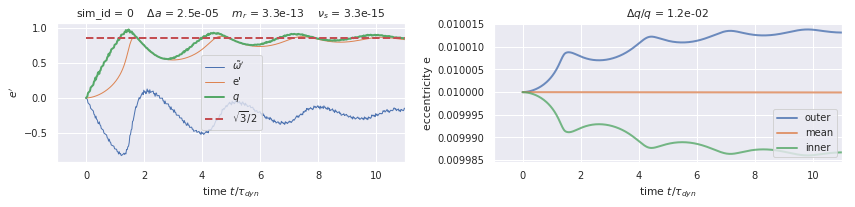

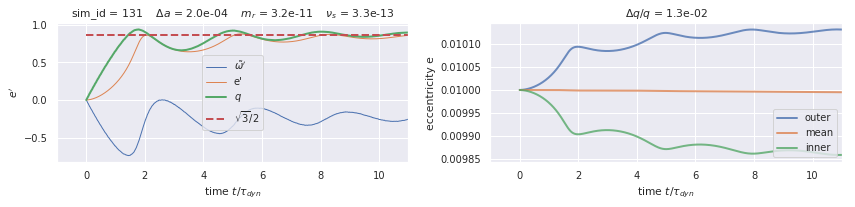

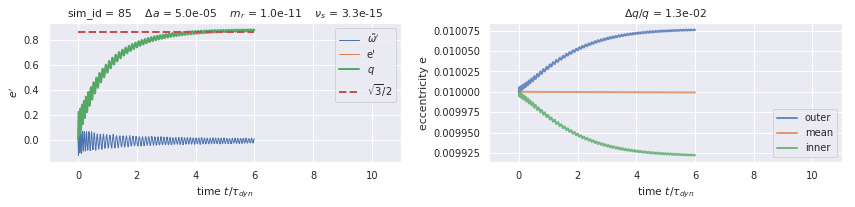

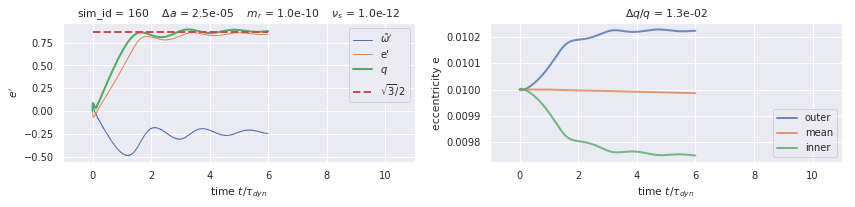

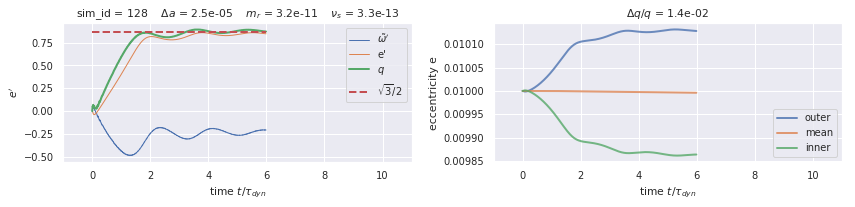

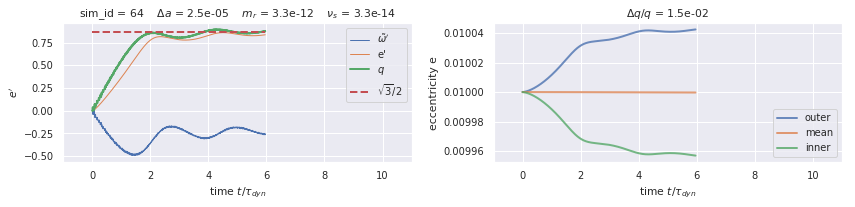

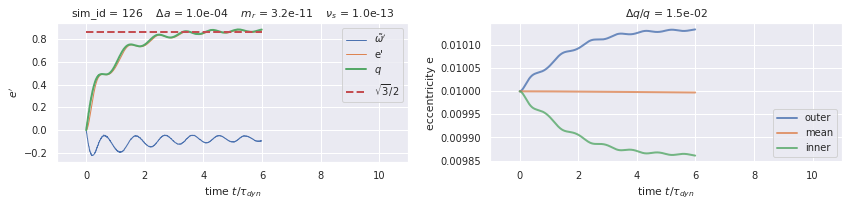

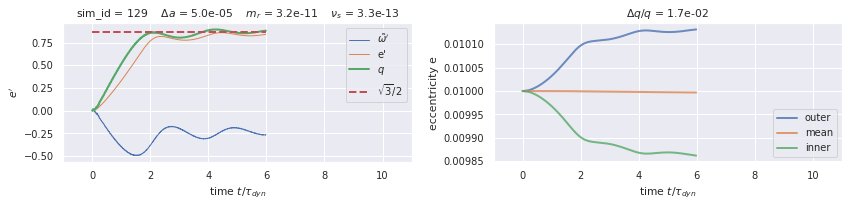

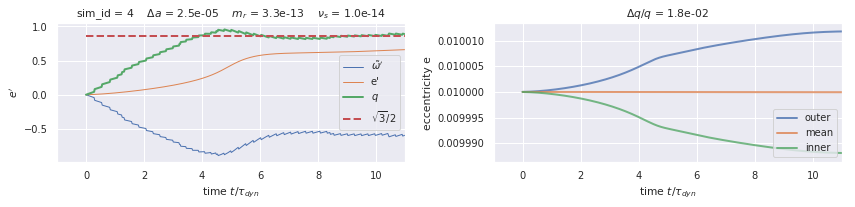

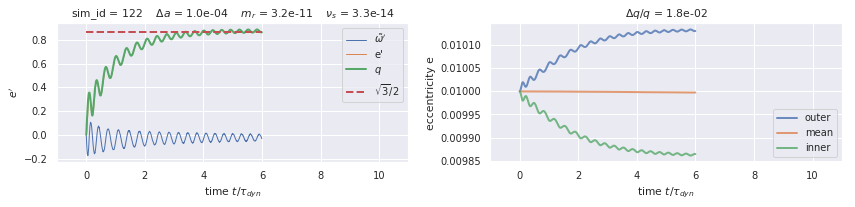

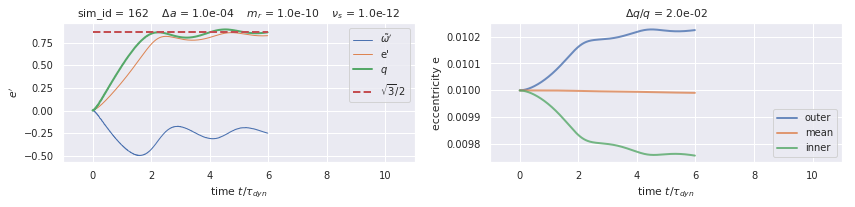

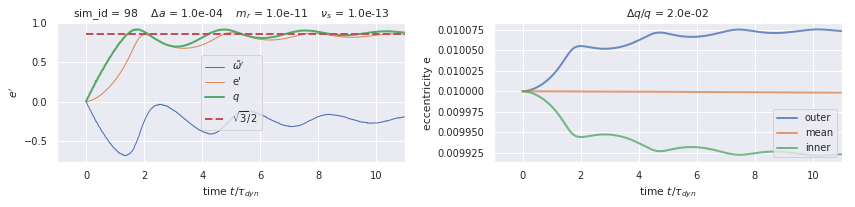

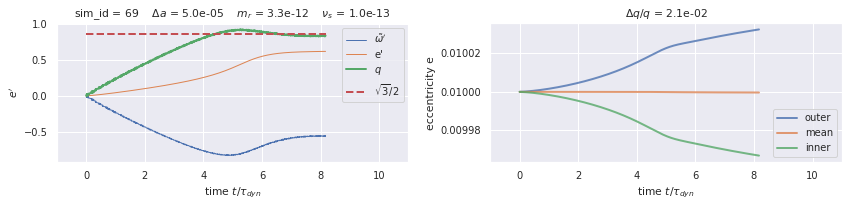

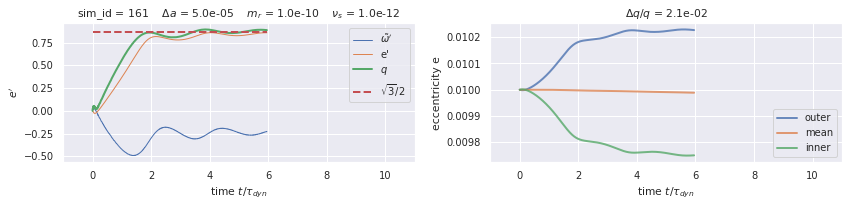

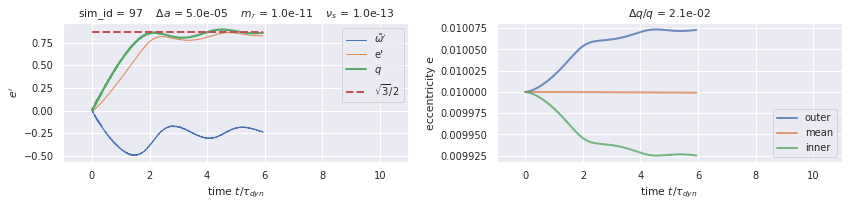

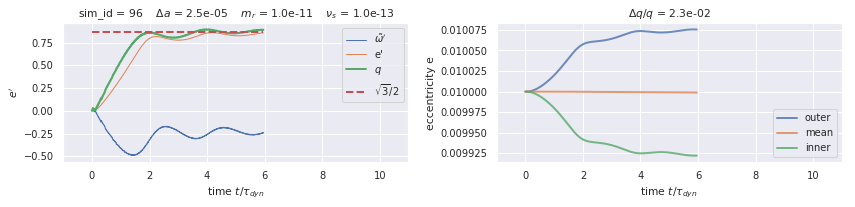

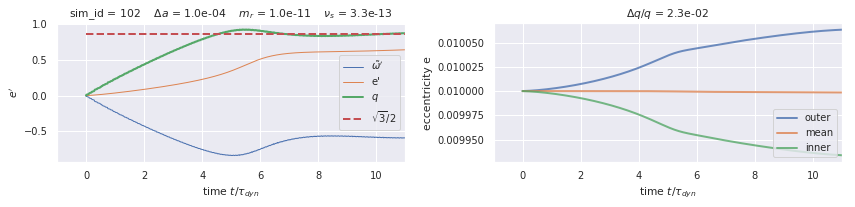

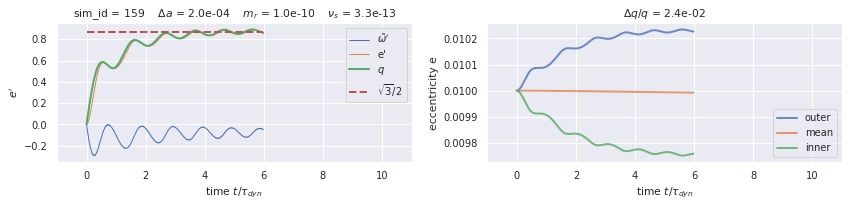

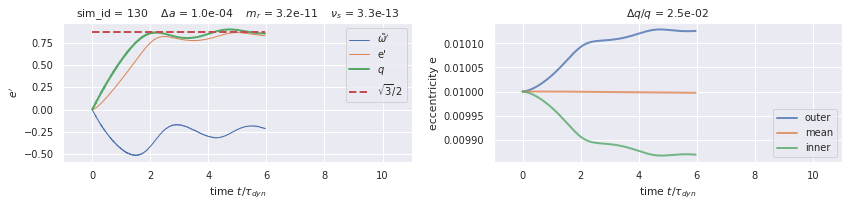

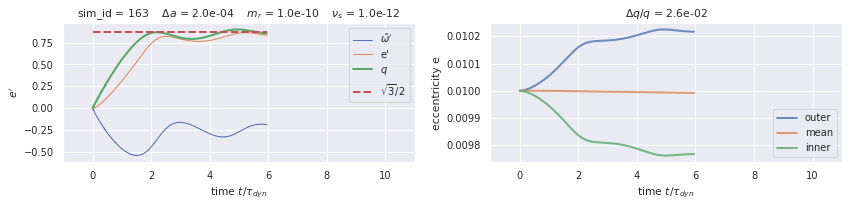

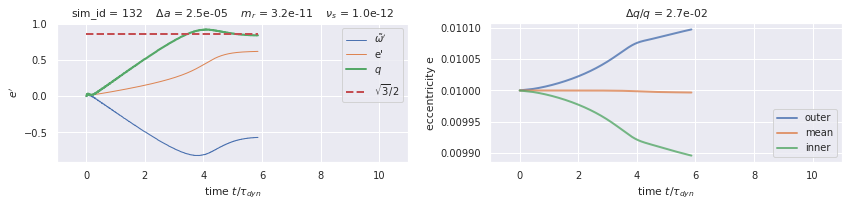

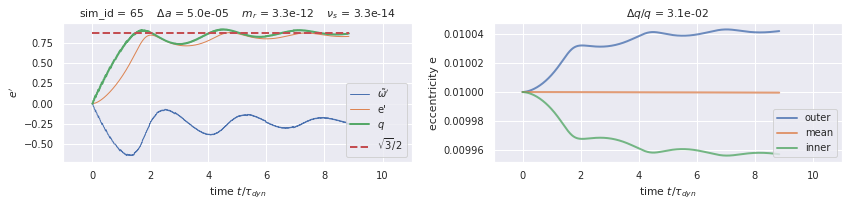

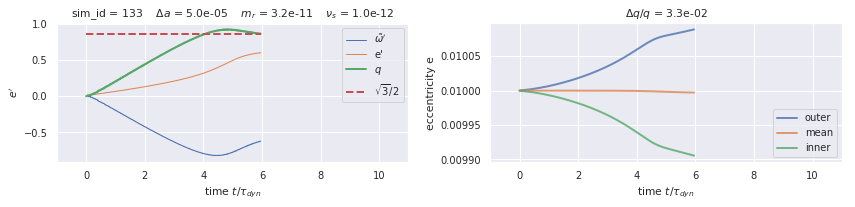

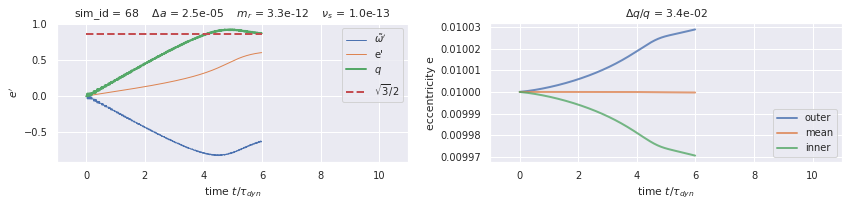

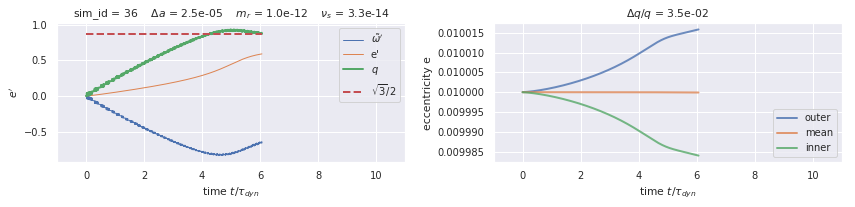

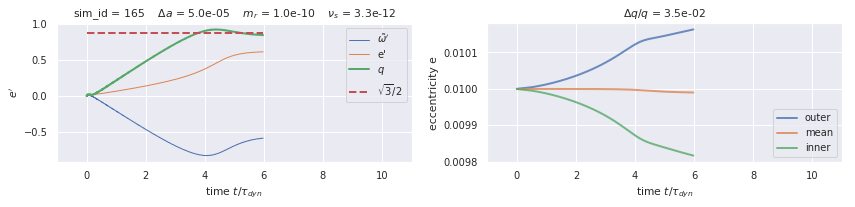

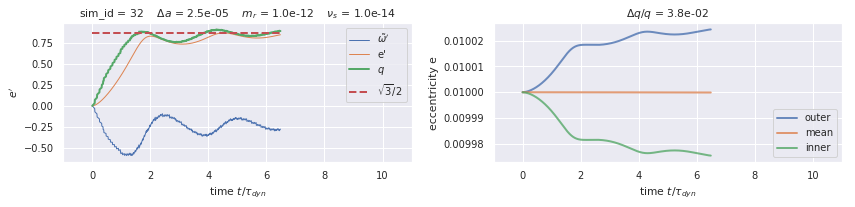

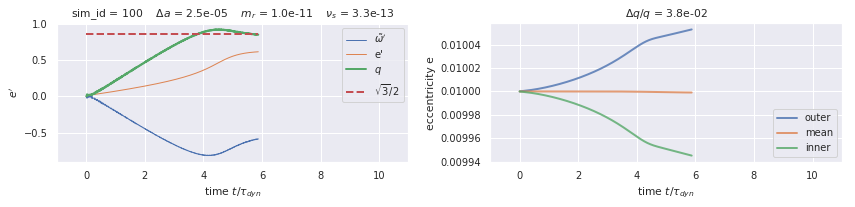

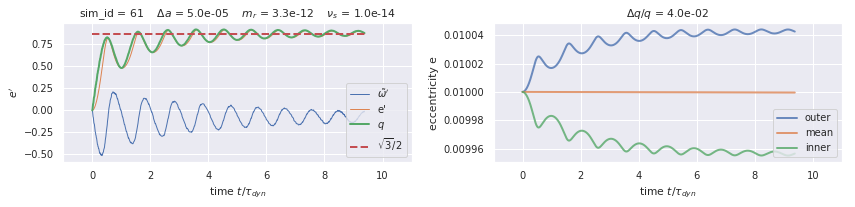

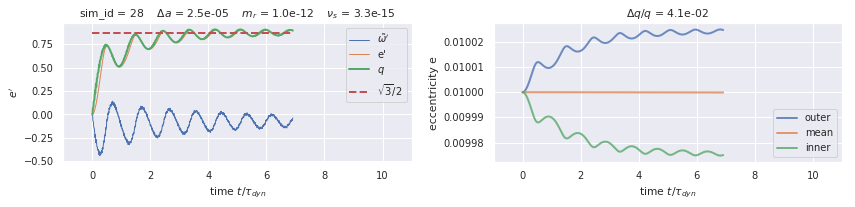

In [156]:
#generate summary plots for all self-confining ringlets whose delta_q_over_q < max_delta_q_over_q
df = df_results
xlim = (-1, 11)
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket > min_e_prime_bracket) \
    & (df.delta_q_over_q < max_delta_q_over_q)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of self-confining sims with (delta_q_over_q < max_delta_q_over_q) = ', len(dfs)
for idx, row in dfs.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=0.9, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

In [157]:
#use linear regression to infer dynamical_timescale, alpha, beta, gamma
df = df_results
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket > min_e_prime_bracket) & \
    (df.delta_q_over_q < max_delta_q_over_q)
df = df[idx].copy()
print 'number of simulations = ', len(df)
df['ln_t_dyn'] = np.log(df.dynamical_timescale_obs)
df['ln_m'] = np.log(df.total_ring_mass/nominal_total_ring_mass)
df['ln_nu'] = np.log(df.shear_viscosity/nominal_shear_viscosity)
df['ln_da'] = np.log(df.radial_width/nominal_radial_width)
x_cols = ['ln_m', 'ln_nu', 'ln_da']
target = 'ln_t_dyn'
X = df[x_cols]
y = df[target]
from sklearn import linear_model
model = linear_model.LinearRegression()
model = model.fit(X, y)
intercept_ = model.intercept_
print 'intercept_ = ', intercept_
coef_ = model.coef_
print 'coef_ = ', coef_
print 'x_cols = ', x_cols
nominal_dynamical_timescale = np.exp(intercept_)
print 'nominal_dynamical_timescale = ', nominal_dynamical_timescale
mass_power_law = coef_[0]
print 'mass_power_law = ', mass_power_law
viscosity_power_law = coef_[1]
print 'viscosity_power_law = ', viscosity_power_law
width_power_law = coef_[2]
print 'width_power_law = ', width_power_law

number of simulations =  55
intercept_ =  10.34122884926178
coef_ =  [ 0.85843983 -0.71945854 -0.21523272]
x_cols =  ['ln_m', 'ln_nu', 'ln_da']
nominal_dynamical_timescale =  30984.081428140875
mass_power_law =  0.8584398287761698
viscosity_power_law =  -0.7194585358560641
width_power_law =  -0.21523271720924717


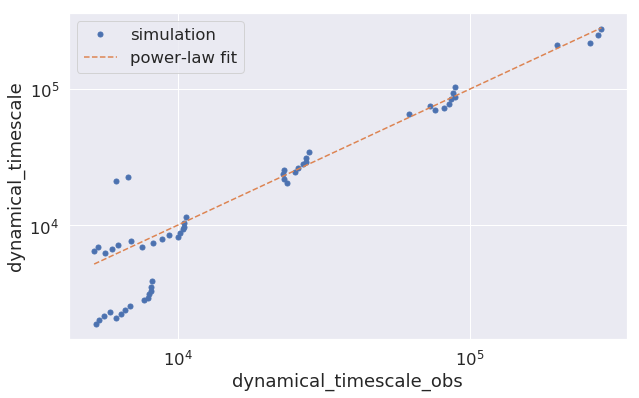

In [161]:
df = df.sort_values('dynamical_timescale_obs')
xp = df.dynamical_timescale_obs
yp = df.dynamical_timescale
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=5, label='simulation')
yp = xp
p = ax.plot(xp, yp, linestyle='dashed', label='power-law fit')
p = ax.set_xlabel('dynamical_timescale_obs')
p = ax.set_ylabel('dynamical_timescale')
p = ax.set_xscale('log')
p = ax.set_yscale('log')
p = ax.legend()

number of e_prime_bracket=0.8 sims =  41
number of sims plotted =  5


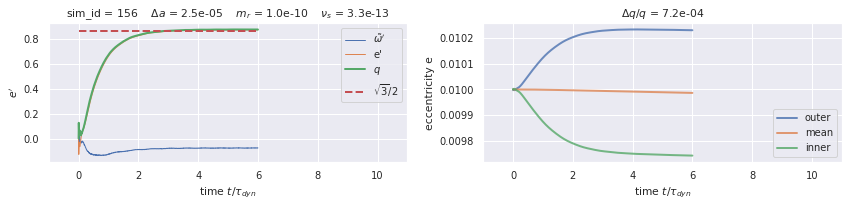

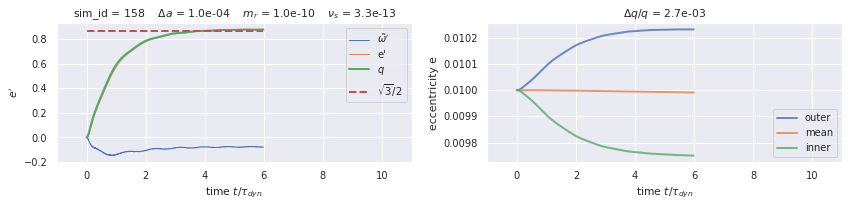

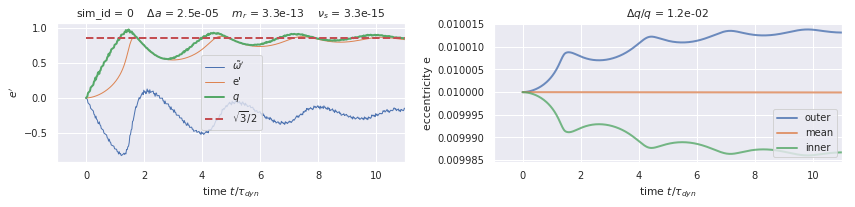

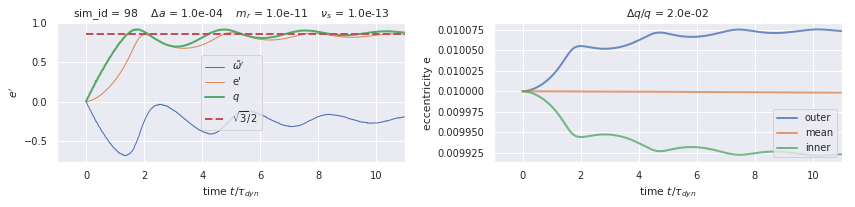

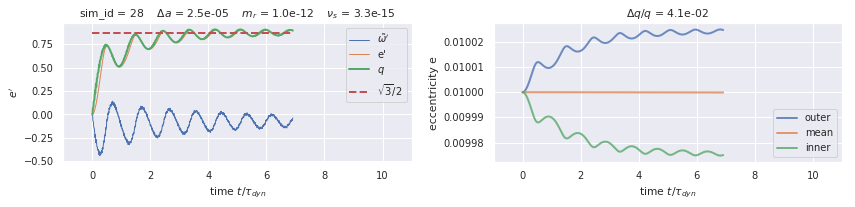

In [144]:
#generate summary plots for sample of e_prime_bracket=0.8 sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.8
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.8 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=0.9, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.5 sims =  14
number of sims plotted =  5


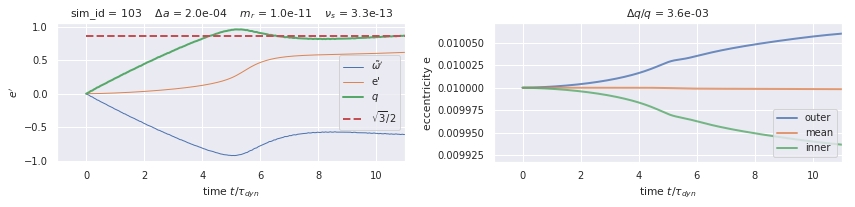

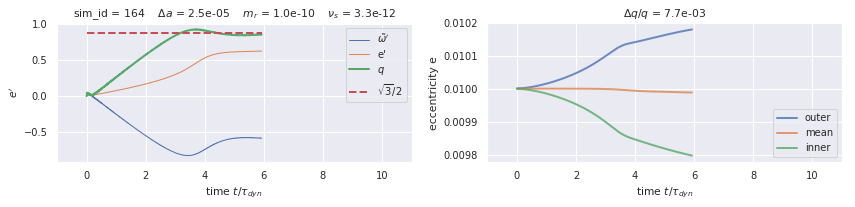

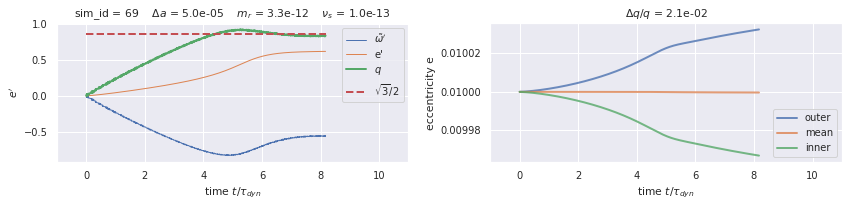

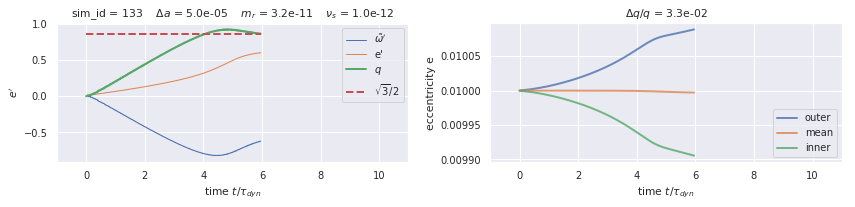

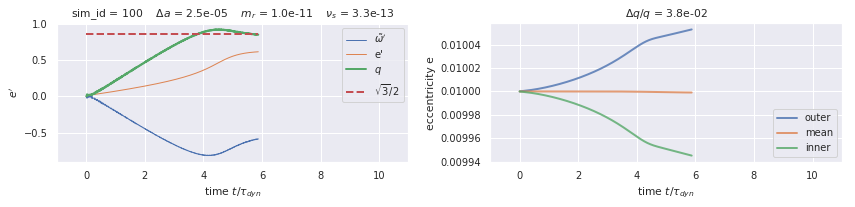

In [145]:
#generate summary plots for sample of e_prime_bracket=0.5 (ie 0.5<e'<0.8) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.5
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.5 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=0.9, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.2 sims =  10
number of sims plotted =  5


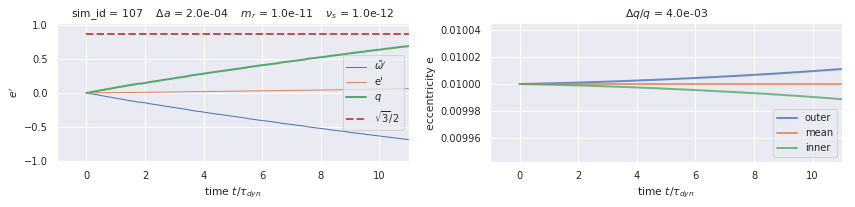

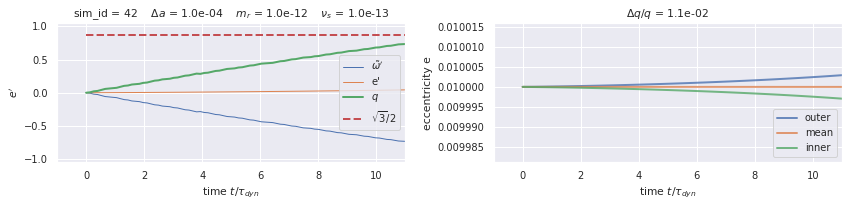

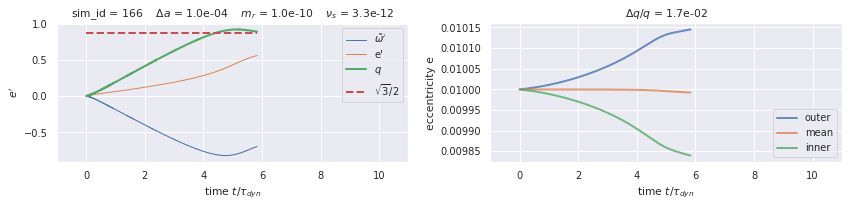

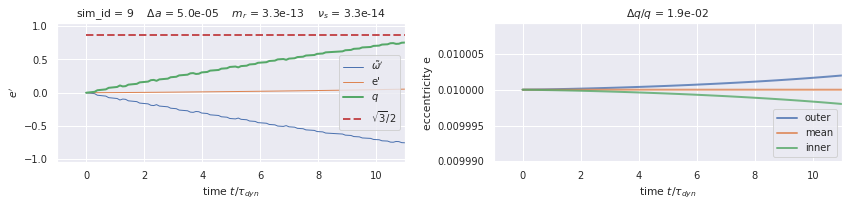

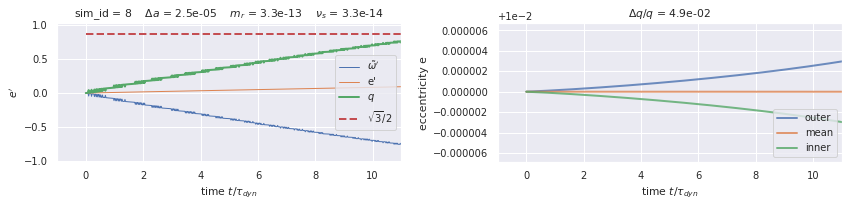

In [146]:
#generate summary plots for sample of e_prime_bracket=0.2 (ie 0.2<e'<0.5) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.2
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.2 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=0.9, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.0 sims =  7
number of sims plotted =  5


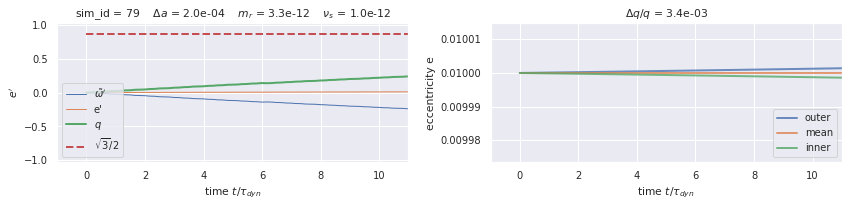

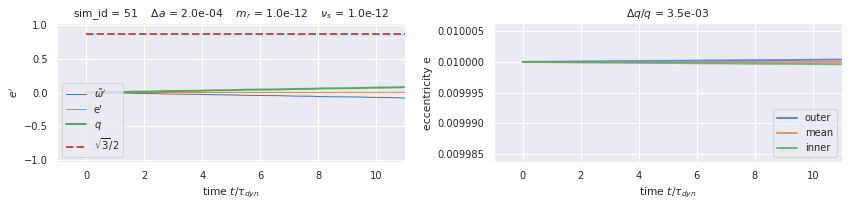

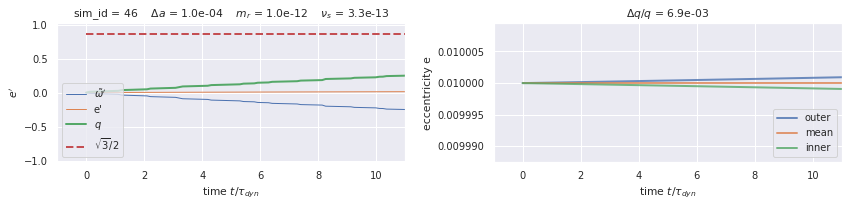

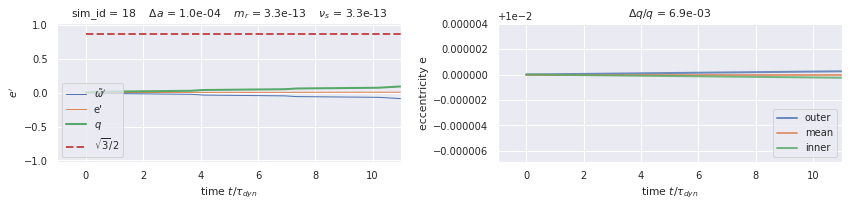

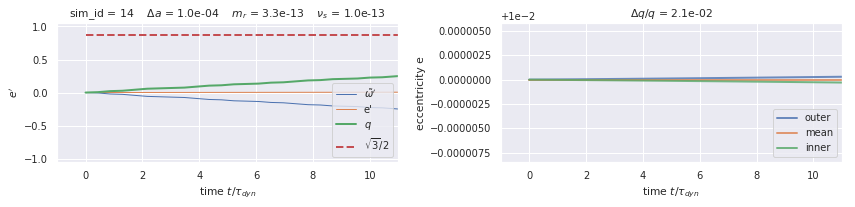

In [147]:
#generate summary plots for sample of e_prime_bracket=0.0 (ie 0.0<e'<0.2) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.0
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.0 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=0.9, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

In [ ]:
stopit

In [ ]:
#list all sims that evolved into self-confining state
df = df_results
idx = (df.outcome == 'crossed streamlines')
print 'fraction of sims having crossed streamlines = ', idx.sum()*1.0/len(idx)
idx = (df.outcome == 'self-confining') | (df.outcome == 'partially confined')
print 'fraction of sims that execute to completion = ', idx.sum()*1.0/len(idx)
idx = (df.outcome == 'self-confining')
print 'fraction of sims that evolve to self-confining state = ', idx.sum()*1.0/len(idx)
idx = (df.outcome == 'unsure')
print 'fraction of sims that evolve to unsure state = ', idx.sum()*1.0/len(idx)
df.outcome.value_counts()

In [ ]:
##set power laws for ringlet's dynamical timescale = time for q to reach 0.6, which is assumed to vary as 
##(ringlet_mass**mass_power_law)*(viscosity**viscosity_power_law)*(radial_width**width_power_law)
#mass_power_law = 1.0
#viscosity_power_law = -1.0
#width_power_law = 0.0

In [ ]:
#list self-confining sims ordered by delta_q
df = df_results
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket > 0.7)
df = df[idx]
df = df.sort_values('delta_q')
cols = ['sim_id', 'total_ring_mass', 'radial_width', 'shear_viscosity', 'q', 'delta_q', 'e_prime', 'outcome']
df[cols]

In [ ]:
#plot q(t/t_dyn)for self-confining sims
df = df_results
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket > 0.7)
dfs = df[idx]
sim_ids = dfs.sim_id.unique()
xlim = (-0.2, 22.2)
#xlim = (-0.1, 10.1)
ylim = (0.0, 1.0)
qts = []
sns.set(font_scale=1.0, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(13, 8))
for sim_id in sim_ids:
    idx = (df.sim_id == sim_id)
    dfs = df[idx]
    try:
        path = dfs.path.values[0]
        delta_q = dfs.delta_q.values[0]
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        #compute time in units of ringlet's dynamical timescale
        #dynamical_timescale = nominal_dynamical_timescale
        #dynamical_timescale *= (total_ring_mass/nominal_total_ring_mass)**mass_power_law
        #dynamical_timescale *= (shear_viscosity/nominal_shear_viscosity)**viscosity_power_law
        #dynamical_timescale *= (radial_width/nominal_radial_width)**width_power_law
        dynamical_timescale = dfs.dynamical_timescale.values[0]
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
        da_init = da[0]
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot q versus time
        xp = times_dynamical
        yp = q
        sim_id_str = str(sim_id)
        if (len(sim_id_str) < 3):
            sim_id_str = '  ' + sim_id_str + '  '
        label = 'ID = ' + sim_id_str
        label += '\t' + r'$m_{ring}=$' + '{:.1e}'.format(total_ring_mass)
        label += '\t' + r'$\nu_s=$' + '{:.1e}'.format(shear_viscosity)
        label += '\t\t' + r'$\Delta a =$' + str(radial_width)
        linewidth = 1
        color = None
        if (sim_id == 120):
            linewidth = 4
            color = color_seq[3]
        p = ax.plot(xp, yp, linestyle='-', linewidth=linewidth, color=color, label=label)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('q')
        p = ax.set_xlim(xlim)
        p = ax.set_ylim(ylim)
        p = ax.legend(loc=(0.18, 0.04), fontsize=8, ncol=2)
        d = {'times':times, 'q':q, 'total_ring_mass':total_ring_mass, 'shear_viscosity':shear_viscosity, 
            'radial_width':radial_width}
        qts += [d]
    except:
        print('sim_id = ', sim_id)
file = 'figs/q_vs_ID.pdf'
plt.savefig(file, bbox_inches='tight')

In [ ]:
# for selected sim_ids showing low librations, plot q(t/t_dyn)
df = df_results
sim_id_groups = [[220, 235], [335, 336, 346, 345, 355], [450, 456, 466, 460, 462, 470], [566, 570, 572], 
    [576, 580, 582, 586], [688, 690, 691, 692, 698, 700, 701, 702], [716, 814, 817, 818, 822, 824]]
xlim = (-0.5, 20.5)
ylim = (0.0, 1.0)
qts = []
for sim_id_group_idx, sim_id_group in enumerate(sim_id_groups):
    sns.set(font_scale=1.5, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    for idx, sim_id in enumerate(sim_id_group):
        jdx = (df.sim_id == sim_id)
        dfs = df[jdx]
        path = dfs.path.values[0]
        delta_q = dfs.delta_q.values[0]
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        #compute time in units of ringlet's dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/5.0e-10)**mass_power_law
        dynamical_timescale *= (shear_viscosity/2.5e-12)**viscosity_power_law
        dynamical_timescale *= (radial_width/0.0003)**width_power_law
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot q versus time
        ax = axs[0]
        xp = times_dynamical
        yp = q
        sim_id_str = str(sim_id)
        if (len(sim_id_str) < 3): sim_id_str = '  ' + sim_id_str + '  '
        label = r'$m_{ring}=$' + '{:.1e}'.format(total_ring_mass)
        label += '\t' + r'$\nu_s=$' + '{:.1e}'.format(shear_viscosity)
        p = ax.plot(xp, yp, linestyle='-', linewidth=2, label=label)
        #yp = wt_prime
        #p = ax.plot(xp, yp, linestyle='-', linewidth=2, label='')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('q')
        p = ax.set_xlim(xlim)
        p = ax.set_ylim(ylim)
        p = ax.legend(loc='lower right')
        #plot da versus time
        ax = axs[1]
        xp = times_dynamical
        yp = da#/radial_width
        label = 'ID = ' + sim_id_str
        label += '\t' + r'$\Delta a =$' + str(radial_width)
        color = color_seq[idx]
        p = ax.plot(xp, yp, linestyle='-', linewidth=2, color=color, label=label)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta a$')
        p = ax.set_xlim(xlim)
        p = ax.legend(loc='lower right')
        #plot streamline's e-evolution
        ax = axs[2]
        xp = times_dynamical
        yp = e_outer
        color = color_seq[idx]
        p = ax.plot(xp, yp, linestyle='-', linewidth=2, alpha=0.8, color=color)
        if (idx == 0):
            xy = (xp[-1] + 0.21, yp[-1])
            p = ax.annotate('outer', xy=xy)
        yp = e_mean
        p = ax.plot(xp, yp, linestyle='-', linewidth=2, alpha=0.8, color=color)
        if (idx == 0):
            xy = (xp[-1] + 0.21, yp[-1])
            p = ax.annotate('mean', xy=xy)
        yp = e_inner
        p = ax.plot(xp, yp, linestyle='-', linewidth=2, alpha=0.8, color=color)
        if (idx == 0):
            xy = (xp[-1] + 0.21, yp[-1])
            p = ax.annotate('inner', xy=xy)
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_xlim(xlim)
        p = ax.legend(loc='lower left')
        p = plt.tight_layout()
    #show q=0.867 threshold
    ax = axs[0]
    xp = times_dynamical
    yp = xp*0 + np.sqrt(3.0)/2.0
    p = ax.plot(xp, yp, linestyle='dashed', alpha=1.0, color='gray', label=r'$q=\sqrt{3}/2$')
    p = ax.legend(loc='lower right')
    file = 'figs/low_libration_sims_'+ str(sim_id_group_idx) + '.pdf'
    plt.savefig(file, bbox_inches='tight')

In [ ]:
#e_damping
df = df_results
sns.set(font_scale=1.3, font='DejaVu Sans')
fig, ax = plt.subplots(figsize=(13, 8))
for sim_id in sim_ids:
    idx = (df.sim_id == sim_id)
    dfs = df[idx]
    path = dfs.path.values[0]
    delta_q = dfs.delta_q.values[0]
    #read simulation input and revised output
    execfile('inputs.py')
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    #get a_mean, e_mean
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    #e-damping
    jdx = 200
    a_sub = a_mean[jdx:]
    e_sub = e_mean[jdx:]
    times_sub = times[jdx:]
    a0 = a_sub[0]
    e0 = e_sub[0]
    w0 = Omega(J2, Rp, a0)
    I_ep = 0.889
    tau_e = 2*a0*a0*e0*e0/(9*I_ep*shear_viscosity)
    xp = (times_sub - times_sub[0])/tau_e
    yp = e_sub/e0
    sim_id_str = str(sim_id)
    if (len(sim_id_str) < 3):
        sim_id_str = '  ' + sim_id_str + '  '
    label = 'ID = ' + sim_id_str
    linewidth = 1
    if (sim_id == 345):
        linewidth = 8
    p = ax.plot(xp, yp, linestyle='-', linewidth=linewidth, label=label)
    p = ax.set_xlabel(r'time $t/\tau_e$')
    p = ax.set_ylabel(r'eccentricity $e(t)/e_0$')
    print ('sim_d = ', sim_id_str, 'max(x) = ', xp[-1], 'delta_q = ', delta_q)
yp = np.sqrt(1 - xp)
p = ax.plot(xp, yp, linestyle='dashed', linewidth=3, alpha=0.8, label='theory')
p = ax.legend(loc=(0.37,0.72), fontsize=10, ncol=5)
file = 'figs/e_vs_tau_e.pdf'
plt.savefig(file, bbox_inches='tight')

In [ ]:
df_results.outcome.value_counts()

In [ ]:
df_results.shear_viscosity.min(), df_results.shear_viscosity.max()

In [ ]:
df_results.total_ring_mass.min(), df_results.total_ring_mass.max()

In [ ]:
radial_widths = np.sort(df.radial_width.unique())
radial_widths

In [ ]:
#show grid of simulation outcomes
df = df_results
#partial_ids = [814, 819, 824, 829, 724, 619, 514, 619, 304, 99]
delta_qs = [(-1, 6.0e-4, r'$\Delta q<6\times10^{-4}$', color_seq[0]), 
            (6.0e-4, 4.0e-3, r'$6\times10^{-4}<\Delta q<4\times10^{-3}$', color_seq[2]), 
            (4.0e-3, 11, r'$\Delta q> 4\times10^{-3}$', color_seq[1])]
radial_widths = np.sort(df.radial_width.unique())
for radial_width in radial_widths:
    idx = (df.radial_width == radial_width)
    dfs = df[idx]
    sns.set(font_scale=1.5, font='DejaVu Sans')
    f, ax = plt.subplots(figsize=(10, 6))
    #indicate sims that didnt complete
    idx = (dfs.outcome == 'crossed streamlines')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=8, color='grey', label='crossed streamlines')
    #self confining sims
    idx = (dfs.outcome == 'self-confining')
    dfss = dfs[idx]
    for delta_q_min, delta_q_max, label, color in delta_qs:
        idx = ((dfss.delta_q > delta_q_min) & (dfss.delta_q <= delta_q_max))
        dfsss = dfss[idx]
        xp = dfsss.shear_viscosity
        yp = dfsss.total_ring_mass
        p = ax.plot(xp, yp, linestyle='none', marker='s', markersize=8, label=label, color=color)
    ##label sims appearing in above plot
    #for sim_id in sim_ids:
    #    idx = (dfs.sim_id == sim_id)
    #    dfss = dfs[idx]
    #    try:
    #        xp = dfss.shear_viscosity.values[0]
    #        yp = dfss.total_ring_mass.values[0]
    #        xy = (0.88*xp, 1.13*yp)
    #        p = ax.annotate(sim_id, xy, fontsize=12)
    #    except:
    #        pass
    #partially confined sims
    idx = (dfs.outcome == 'partially confined')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    color = color_seq[6]
    p = ax.plot(xp, yp, linestyle='none', marker='D', markersize=8, color=color, label='partially confined')
    ##label sims in partial_ids that appear in next plot
    #for sim_id in partial_ids:
    #    idx = (dfss.sim_id == sim_id)
    #    dfsss = dfss[idx]
    #    try:
    #        xp = dfsss.shear_viscosity.values[0]
    #        yp = dfsss.total_ring_mass.values[0]
    #        xy = (0.88*xp, 1.13*yp)
    #        p = ax.annotate(sim_id, xy, fontsize=12, color=color)
    #    except:
    #        pass
    p = ax.set_xscale('log')
    p = ax.set_yscale('log')
    p = ax.set_xlabel(r'viscosity $\nu_s$')
    p = ax.set_ylabel(r'ring mass $m_r$')
    title = r'$\Delta a_0 = $' + str(radial_width)
    p = ax.set_title(title)
    p = ax.set_ylim(1.0e-13, 7.0e-10)
    p = ax.set_xlim(1.0e-15, 1.0e-11)
    if (radial_width == 0.0002):
        p = ax.legend(loc=(1.02, 0.3))
    file = 'figs/sim_grid_da_'+ str(radial_width).replace('.', 'p') + '.pdf'
    plt.savefig(file, bbox_inches='tight')

In [ ]:
print ('partial_ids = ', partial_ids)

In [ ]:
#show range of sim parameters
df = df_results
print 'total_ring_mass = ', df.total_ring_mass.unique()
print 'radial_width = ', df.radial_width.unique()
print 'shear_viscosity = ', df.shear_viscosity.unique()

In [ ]:
#generate grid of summary plots, for each sim that is partially confined
df = df_results
xlim = (-0.2, 20.2)
radial_widths = df.radial_width.unique()
for radial_width in radial_widths:
    idx = (df.radial_width == radial_width) & (df.outcome == 'partially confined')
    dfs = df[idx].sort_values(['total_ring_mass', 'shear_viscosity'])
    for idx, row in dfs.iterrows():
        #read simulation input and revised output
        execfile('inputs.py')
        path = row.path
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        viscous_timescale = (row.radial_width**2)/(12*np.abs(row.shear_viscosity))
        times_viscous = times/viscous_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        da_init = da[0]
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #create grid of plots
        sns.set(font_scale=1.45, font='DejaVu Sans')
        fig, axs = plt.subplots(1, 3, figsize=(24, 6))
        #plot streamline's mutual a-evolution
        ax = axs[0]
        x = times_viscous
        y = da/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$\Delta a/\Delta a_0$')
        y = (a_outer - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='outer')
        y = (a_mean - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='mean')
        y = (a_inner - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='inner')
        p = ax.set_xlabel(r'time $t/\tau_\nu$')
        p = ax.set_ylabel('(a - a$_{mean})/\Delta a_0$')
        sim_id = row.sim_id
        total_ring_mass = row.total_ring_mass
        title = 'sim_id=' + str(sim_id) + '    total_ring_mass=' + '{:.1e}'.format(total_ring_mass)
        p = ax.set_title(title)
        p = ax.legend()
        p = plt.tight_layout()
        #plot streamline's e-evolution
        ax = axs[1]
        x = times_viscous
        y = e_outer
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
        y = e_mean
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
        y = e_inner
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'time $t/\tau_\nu$')
        radial_width = row.radial_width
        title = 'radial_width=' + str(radial_width)
        p = ax.set_title(title)
        p = ax.legend()
        p = plt.tight_layout()
        #plot e_prime wt_prime and q versus time
        ax = axs[2]
        x = times_viscous
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
        if ((e_prime[-1] > 0.6) or (e_prime[-1] < 0.05)):
            print 'sim_id = ', sim_id, 'e_prime = ', e_prime[-1]
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
        p = ax.plot(x[-1], y[-1], marker='o', markersize=10, label='')
        p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
        shear_viscosity = row.shear_viscosity
        title = 'viscosity=' + '{:.1e}'.format(shear_viscosity)
        p = ax.set_title(title)
        p = ax.set_xlabel(r'time $t/\tau_\nu$')
        p = ax.set_ylabel(r"$e'$")
        p = ax.legend()
        p = plt.tight_layout()

In [ ]:
#for q, e_prime, wt_prime vs time, for selected sims that are partially self-confined
df = df_results
partial_ids = [345] + partial_ids
print ('partial_ids = ', partial_ids)
xlim = (-0.2, 20.2)
ylim = (-0.05, 1.0)
sns.set(font_scale=1.3, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(13, 8))
for idx, sim_id in enumerate(partial_ids):
    jdx = (df.sim_id == sim_id)
    dfs = df[jdx]
    try:
        path = dfs.path.values[0]
        delta_q = dfs.delta_q.values[0]
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        viscous_timescale = (d['radial_width']**2)/(12*np.abs(d['shear_viscosity']))
        times_viscous = times/viscous_timescale
        #compute time in units of ringlet's dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/5.0e-10)**mass_power_law
        dynamical_timescale *= (shear_viscosity/2.5e-12)**viscosity_power_law
        dynamical_timescale *= (radial_width/0.0003)**width_power_law
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot q versus time
        xp = times_dynamical
        yp = q
        color = color_seq[idx%len(color_seq)]
        #p = ax.plot(xp, yp, linestyle='dotted', color=color, linewidth=linewidth)
        sim_id_str = str(sim_id)
        if (len(sim_id_str) < 3):
            sim_id_str = '  ' + sim_id_str + '  '
        linewidth = 2
        #p = ax.plot(xp, yp, linestyle='dotted', color=color, linewidth=linewidth)
        #plot e_prime versus time
        yp = e_prime
        p = ax.plot(xp, yp, linestyle='-', color=color, linewidth=linewidth)
        p = ax.annotate(sim_id_str, (20.2, yp[-1]), color=color)
        print 'sim_id = ', sim_id, 'da_0 = ', da[0], 'idx = ', idx, 'e_prime = ', e_prime[-1]
    except:
        pass
xp = np.array([0, 20])
yp = xp*0 + np.sqrt(3.0)/2.0
color = color_seq[3]
p = ax.plot(xp, yp, linestyle='dotted', linewidth=2, color=color)
p = ax.annotate(r"$e'=\sqrt{3}/2$", (0.65, 0.88), color='black')
ringlets = {'Maxwell':0.663, 'Titan':0.425, 'Laplace':0.039, 'Huygens':0.012}
color = 'black'
for ringlet, e_prime in ringlets.iteritems():
    xp = np.array([16.5, 19.2])
    yp = xp*0 + e_prime
    p = ax.plot(xp, yp, linestyle='-', linewidth=2, color=color)
    xy = (17.0, e_prime+0.013)
    if (ringlet == 'Huygens'):
        xy = (17.0, e_prime-0.037)
    p = ax.annotate(ringlet, xy, color=color)
p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
p = ax.set_ylabel(r"$e'$")
p = ax.set_xlim(xlim)
p = ax.set_ylim(ylim)
file = 'figs/e_prime_q_vs_time.pdf'
plt.savefig(file, bbox_inches='tight')

In [ ]:
#e_damping for partially confined ringlets
df = df_results
sns.set(font_scale=1.3, font='DejaVu Sans')
fig, ax = plt.subplots(figsize=(13, 8))
for sim_id in partial_ids:
    idx = (df.sim_id == sim_id)
    dfs = df[idx]
    path = dfs.path.values[0]
    delta_q = dfs.delta_q.values[0]
    #read simulation input and revised output
    execfile('inputs.py')
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    #get a_mean, e_mean
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    #e-damping
    jdx = 200
    a_sub = a_mean[jdx:]
    e_sub = e_mean[jdx:]
    times_sub = times[jdx:]
    a0 = a_sub[0]
    e0 = e_sub[0]
    w0 = Omega(J2, Rp, a0)
    I_ep = 0.889
    tau_e = 2*a0*a0*e0*e0/(9*I_ep*shear_viscosity)
    xp = (times_sub - times_sub[0])/tau_e
    yp = e_sub/e0
    sim_id_str = str(sim_id)
    if (len(sim_id_str) < 3):
        sim_id_str = '  ' + sim_id_str + '  '
    label = 'ID = ' + sim_id_str
    linewidth = 1
    if (sim_id == 345):
        linewidth = 8
    p = ax.plot(xp, yp, linestyle='-', linewidth=linewidth, label=label)
    p = ax.set_xlabel(r'time $t/\tau_e$')
    p = ax.set_ylabel(r'eccentricity $e(t)/e_0$')
    da_over_a = da[-1]/a_mean[0]
    de_over_e = de[-1]/e_mean[0]
    ratio = da_over_a/de_over_e
    print ('sim_d = ', sim_id_str, 'da/a = ', da_over_a, 'de/e = ', de_over_e, 'ratio = ', str(ratio)[0:5])
xp = np.array([0.0, 0.55])
yp = np.sqrt(1 - xp)
p = ax.plot(xp, yp, linestyle='dashed', linewidth=3, alpha=0.8, label='theory')
p = ax.legend(loc=(0.37,0.72), fontsize=10, ncol=5)

In [ ]:
#plot wt_prime versus time for constant mass
df = df_results
ids = [335, 340, 345, 350, 355]
shear_viscosity_nominal = 2.5e-12
xlim = (-0.2, 20.2)
ylim = (-0.52, 0.02)
sns.set(font_scale=1.3, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(13, 8))
for idx, sim_id in enumerate(ids):
    jdx = (df.sim_id == sim_id)
    dfs = df[jdx]
    try:
        path = dfs.path.values[0]
        delta_q = dfs.delta_q.values[0]
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        radial_width = d['radial_width']
        shear_viscosity = d['shear_viscosity']
        viscous_timescale = (radial_width**2)/(12*np.abs(shear_viscosity))
        times_viscous = times/viscous_timescale
        #compute time in units of ringlet's dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/5.0e-10)**mass_power_law
        dynamical_timescale *= (shear_viscosity/2.5e-12)**viscosity_power_law
        dynamical_timescale *= (radial_width/0.0003)**width_power_law
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot wt_prime versus time
        xp = times_dynamical
        yp = wt_prime
        color = color_seq[idx]
        relative_shear_viscosity = np.round(shear_viscosity/shear_viscosity_nominal, decimals=1)
        label = "ID = " + str(sim_id) + r"    $\nu_s=$" + str(relative_shear_viscosity) + r"$\nu_{n}$"
        p = ax.plot(xp, yp, color=color, linewidth=2, label=label)
        print (sim_id, shear_viscosity, relative_shear_viscosity)
    except:
        pass
p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
p = ax.set_ylabel(r"$\tilde{\omega}$'")
p = ax.set_xlim(xlim)
p = ax.set_ylim(ylim)
p = ax.legend()
file = 'figs/wt_prime_vs_time.pdf'
plt.savefig(file, bbox_inches='tight')

In [ ]:
#plot wt_prime versus time for constant mass
df = df_results
ids = [240, 345, 450]
total_ring_mass_nominal = 5.0e-10
xlim = (-0.2, 50.2)
ylim = (-0.52, 0.02)
sns.set(font_scale=1.3, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(13, 8))
for idx, sim_id in enumerate(ids):
    jdx = (df.sim_id == sim_id)
    dfs = df[jdx]
    try:
        path = dfs.path.values[0]
        delta_q = dfs.delta_q.values[0]
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        radial_width = d['radial_width']
        shear_viscosity = d['shear_viscosity']
        viscous_timescale = (radial_width**2)/(12*np.abs(shear_viscosity))
        times_viscous = times/viscous_timescale
        #compute time in units of ringlet's dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/5.0e-10)**mass_power_law
        dynamical_timescale *= (shear_viscosity/2.5e-12)**viscosity_power_law
        dynamical_timescale *= (radial_width/0.0003)**width_power_law
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot e_prime versus time
        xp = times_viscous
        yp = e_prime
        color = color_seq[idx]
        relative_total_ring_mass = np.round(total_ring_mass/total_ring_mass_nominal, decimals=1)
        label = "ID = " + str(sim_id) + r"    $\nu_s=$" + str(relative_total_ring_mass) + r"$m_{n}$"
        p = ax.plot(xp, yp, color=color, linewidth=2, label=label)
        print (sim_id, total_ring_mass, relative_shear_viscosity)
    except:
        pass
xp = np.array(xlim)
yp = xp*0 + np.sqrt(3.0)/2.0
color = color_seq[3]
p = ax.plot(xp, yp, linestyle='dotted', linewidth=2, color=color, label=r"$e'=\sqrt{3}/2$")
p = ax.set_xlabel(r'time $t/\tau_{\nu}$')
p = ax.set_ylabel(r"$e'$")
p = ax.set_xlim(xlim)
#p = ax.set_ylim(ylim)
p = ax.legend()
file = 'figs/e_prime_vs_time.pdf'
plt.savefig(file, bbox_inches='tight')

In [ ]:
#done
time_exec_min = (tm.time() - t_start)/60
print 'time_exec_min = ', time_exec_min